tgb - 6/24/2019 - The goal of this notebook is to develop diagnostics targeted at the water budget. The motivation is that we would like to understand how enforcing physical constraints affects performance in a high-dimensional system. Since we enforce that the water budget be closed, we can expect some of its macro-diagnostics to be improved. We will:  
1) Load the conserving and unconstrained networks, optimized by Jordan, and compare their respective "average" performances on (+0K),(+4K) and (+3Kw1)    
2) Calculate different terms of the water vapor budget in each dataset  
3) Formally expand conservation penalty in the water vapor budget

# 1) Load networks and compare average performances on different datasets

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


Load coordinates

In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

R2 maps for a given variable from notebook https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/011_Conserving_Network_Paper_Figures.ipynb

In [3]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc']
data_ref = ['','4K','3Kw1']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
NNarray = ['JNNL','JNNC','MLRL0']

In [5]:
# Variable and variable's dimension
VAR = 'FLNT'
VARdim = 2;

j= 0 and data from  /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc
i = 0  so plotting Subplot # 1
Loading model
Loading statistics
JNNL
MSE 148.5863357842754
i = 1  so plotting Subplot # 2
Loading model
Loading statistics
JNNC
MSE 152.4882037592579
i = 2  so plotting Subplot # 3
Loading model
Loading statistics
MLRL0
MSE 295.2749784945916
j= 1 and data from  /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc
i = 0  so plotting Subplot # 4
Loading model
Loading statistics
JNNL
MSE 346.47582894101373
i = 1  so plotting Subplot # 5
Loading model
Loading statistics
JNNC
MSE 361.74200568262745
i = 2  so plotting Subplot # 6
Loading model
Loading statistics
MLRL0
MSE 746.8456986236632
j= 2 and data from  /local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc
i = 0  so plotting Subplot # 7
Loading model
Loading statistics
JNNL
MSE 211.7587284195847
i = 1  so plotting Subplot # 8
Loading model
Loading statistics
JNNC
MSE 219.8002236374335
i = 2  so plotting Subplot # 9
Loading model
Loading stati

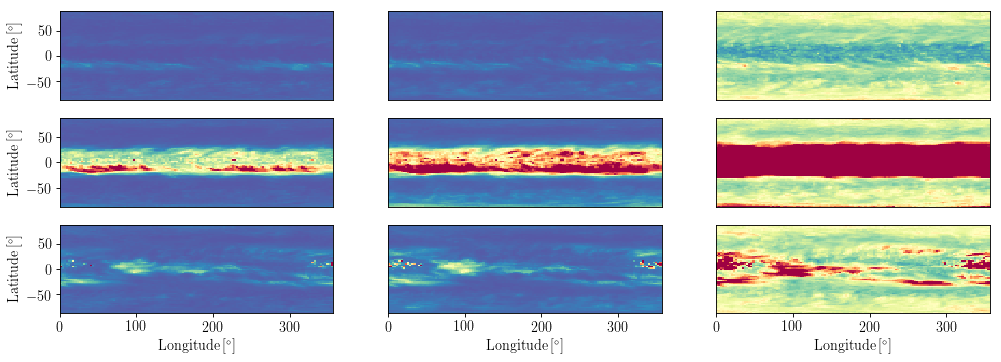

In [15]:
# Loop for R2/penalty performances
msevec = np.zeros((np.size(NNarray),np.size(data_ref),218))

# Prepare figure
fz = 13; # Fontsize
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
fig, axes = plt.subplots(nrows=len(data_fn_a), ncols=len(NNarray),\
                        num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

# Start loop
for j,data_fn in enumerate(data_fn_a):
    print('j=',j,'and data from ',data_fn)
    for i,NNs in enumerate(NNarray):
        print('i =',i,' so plotting Subplot #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        print('Loading model') # 1) Load model
        NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.h5',custom_objects=dict_lay)
        print('Loading statistics') # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)
        
        # 3) Calculate statistics and save in pickle file
        path_end = 'md'+data_ref[j]+'.pkl'
        pathres = 'mdres'+data_ref[j]+'.pkl'
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        #md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+pathres,'rb'))

        print(NNs)
        print('MSE',md.mse_W2m4().mean((0,1,2)))
        msevec[i,j,:] = md.mse_W2m4().mean((0,1)) # Save the MSE for each output
#         print('PEN',0.25*(md.res['mass']+md.res['ent']+\
#                           md.res['sw']+md.res['lw']).mean((0,1,2)))
#         print('PEN_MASS',0.25*(md.res['mass']).mean((0,1,2)))
#         print('PEN_ENT',0.25*(md.res['ent']).mean((0,1,2)))
#         print('PEN_LW',0.25*(md.res['lw']).mean((0,1,2)))
#         print('PEN_SW',0.25*(md.res['sw']).mean((0,1,2)))
        
        if VARdim==3: A = np.expand_dims(md.stats['r2']\
                                         [:, :, md.get_output_var_idx(VAR)[15:30]].mean(axis=2),axis=2).T;
        else: A = md.stats['r2'][:, :, md.get_output_var_idx(VAR)].T; # When single-valued variable
        AX = axes.flat[i+j*len(NNarray)]
        im = AX.pcolor(lon,lat,A[0,:,:].T,cmap='Spectral',vmin=0,vmax=1)
        #AX.set_title(TITarray[i+j*len(NNarray)])
        if j+1==len(data_fn_a): AX.set_xlabel(r'$\mathrm{Longitude}\left[^{\circ}\right]$')
        else: AX.get_xaxis().set_ticks([])
        if i==0: AX.set_ylabel(r'$\mathrm{Latitude}\left[^{\circ}\right]$')
        else: AX.get_yaxis().set_ticks([])

# 2) Water vapor budget terms

## 2.1) Develop diagnostics

### 2.1.1) Define models

In [4]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc']
data_ref = ['','4K','3Kw1']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
NNarray = ['JNNL','JNNC','MLRL0']

In [129]:
index = 0; # Choose dataset from data_fn_a

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn,data_fn_a[index])

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


### 2.1.2) Loop over each timestep and decompose the residual into error on each budget term

In [130]:
# tgb - 6/24/2019 - Define diagnostics to calculate residual from water budget
def dec_res(md, inp, pred):
    inp_div = md.valid_gen.input_transform.div
    inp_sub = md.valid_gen.input_transform.sub
    norm_q = md.valid_gen.output_transform.scale[md.get_output_var_idx('PHQ')]

    # Input
    PS_idx = 300
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    PRECT_idx = 214
    PRECTEND_idx = 215

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute water integral
    WATINT = np.sum(dP_tilde *(pred[:, PHQ_idx] + pred[:, PHCLDLIQ_idx] + pred[:, PHCLDICE_idx]), axis=1)

    # 3. Compute latent heat flux and precipitation forcings
    LHFLX = inp[:, LHFLX_idx] * inp_div[LHFLX_idx] + inp_sub[LHFLX_idx]
    PREC = pred[:, PRECT_idx] + pred[:, PRECTEND_idx]

    # 4. Compute water mass residual
    WATRES = LHFLX - PREC - WATINT

    # 5. Put all terms of water vapor budget in a dictionary
    BUD = {}
    BUD['TOT'] = WATRES
    BUD['LHF'] = LHFLX
    BUD['PREC'] = PREC
    BUD['WAT'] = WATINT
    
    return BUD

The goal is to relate how much our neural network violates the physical
constraints to its performances. Quantitatively, we relate the residual
of a budget (e.g. water) to the error of each of the budget's terms
(i.e. how much the budget's term deviates from the truth): 
$$
\begin{aligned}\mathrm{Residual_{pred}} & \overset{\mathrm{def}}{=}\left(\mathrm{EVAP_{pred}-WATINT_{pred}-PREC_{pred}}\right)^{2}\\
 & =\left(\mathrm{EVAP_{error}-WATINT_{error}-PREC_{error}}\right)^{2}
\end{aligned}
$$
where the error of each component is defined as:
$$
X_{\mathrm{error}}\overset{\mathrm{def}}{=}X_{\mathrm{pred}}-X_{\mathrm{truth}}
$$
and we have used the fact that the residual was 0 for the ``truth'':
$$
\mathrm{Residual_{truth}}=0\ \Rightarrow\ \left(\mathrm{EVAP_{pred}-WATINT_{pred}-PREC_{pred}}\right)=0
$$
We can therefore write $\mathrm{Residual_{pred}}\ $as a function
of the mean-squared-error of each term and the cross-product of different
errors. Since $\mathrm{EVAP}\ $is an input, $\mathrm{EVAP_{error}=0}\ $and:
$$
\mathrm{Residual_{pred}}=\mathrm{WATINT_{error}^{2}+PREC_{error}^{2}+2PREC_{error}\times WATINT_{error}}
$$
This can be decomposed further by decomposing $\mathrm{WATINT,PREC\ }$into
its different terms. Because enforcing physical constraints sets $\mathrm{Residual_{pred}}\ $to
0, it constrains the performances of the network ($\mathrm{WATINT_{error}^{2},PREC_{error}^{2}}$)
via the equation above.
\end{document}


In [131]:
NNarray = ['JNNL','JNNC']
nt = 3
Bdic = ['TOT','LHF','PREC','WAT']
Rdic = ['TOT','PREC','WAT','PREC_WAT']
# Allocate stats arrays
for i,NNs in enumerate(NNarray):
    md[NNs].bud = {}; md[NNs].err = {};
    M = md[NNs]
    bud = {}; err = {}; 
    for iB,Bs in enumerate(Bdic):
            bud[Bs] = np.zeros((M.nlat, M.nlon,1))
    for iR,Rs in enumerate(Rdic):
            err[Rs] = np.zeros((M.nlat, M.nlon,1))
    for itime in tqdm(range(nt)):
        inp, p, truth = M.get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        # residuals
        R = dec_res(M,inp,p) # Predicted water budget
        T = dec_res(M,inp,truth) # True water budget
        # Budget terms
        for iB,Bs in enumerate(Bdic):
            bud[Bs] += M.reshape_ngeo(R[Bs])
        # Absolute errors
        err['PREC'] += M.reshape_ngeo(np.square(R['PREC']-T['PREC']))
        err['WAT'] += M.reshape_ngeo(np.square(R['WAT']-T['WAT']))
        err['PREC_WAT'] += M.reshape_ngeo(2*(R['PREC']-T['PREC'])\
                                             *(R['WAT']-T['WAT']))
        # If the decomposition works, err['TOT']=bud['TOT']
        err['TOT'] += M.reshape_ngeo(np.square(R['TOT']-T['TOT'])) 
            
    # Compute average statistics
    md[NNs].err[Rs] = {}; md[NNs].bud[Bs] = {};
    for iR,Rs in enumerate(Rdic):
        md[NNs].err[Rs] = err[Rs]/nt # Budget term in W2/m4
    for iB,Bs in enumerate(Bdic):
        md[NNs].bud[Bs] = bud[Bs]/nt # Budget term in W2/m4

In [132]:
NNs = 'JNNL'
M = md[NNs]
for iB,Bs in enumerate(Bdic):
    print('Budget',Bs,'=',(M.bud[Bs]**2).mean(axis=(0,1)))
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=',M.err[Rs].mean(axis=(0,1)))

Budget TOT = [113.89429593]
Budget LHF = [10061.27066211]
Budget PREC = [73110.80852278]
Budget WAT = [73567.15017765]
Error TOT = [137.24368105]
Error PREC = [4565.7796635]
Error WAT = [4681.1881103]
Error PREC_WAT = [-9109.72411991]


In [133]:
NNs = 'JNNC'
M = md[NNs]
for iB,Bs in enumerate(Bdic):
    print('Budget',Bs,'=',(M.bud[Bs]**2).mean(axis=(0,1)))
for iR,Rs in enumerate(Rdic):
    print('Error',Rs,'=',M.err[Rs].mean(axis=(0,1)))

Budget TOT = [2.62565967e-10]
Budget LHF = [10061.27066211]
Budget PREC = [76617.01302778]
Budget WAT = [77424.82161996]
Error TOT = [3.95715306e-08]
Error PREC = [4690.58970333]
Error WAT = [4690.59149841]
Error PREC_WAT = [-9381.18122786]


In [134]:
M.ent_res(inp,p).mean(axis=0)

1.7068951e-09

In [98]:
scale_dict = load_pickle('/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [100]:
scale_dict['PHQ']

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)

In [102]:
 M.valid_gen.output_transform.scale[M.get_output_var_idx('PHQ')]

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)